In [1]:
from matplotlib import pyplot as plt
from hddm.simulators import simulator
import hddm
import numpy as np
import pandas as pd
import scipy.sparse as sp
import gc
import sys

sys.path.append("../Codes")
from utils import *
from chain import *


/users/sliu167/anaconda/hddm/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hddm.model_config.model_config["angle"]


{'doc': 'Model formulation is described in the documentation under LAN Extension.\nMeant for use with the extension.',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'params_trans': [0, 0, 1, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'params_default': [0.0, 1.0, 0.5, 0.001, 0.1],
 'hddm_include': ['v', 'a', 't', 'z', 'theta'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'theta': 0.1,
  'theta_std': 0.2}}

In [3]:
out = simulator(model="angle", theta=[1.0, 1.5, 0.5, 0.5, 0.0], n_samples=1000)


In [4]:
# v = 1.0
# a = 1.5
# z = 0.5
# t = 0.5
# theta = 0
rts, choices, metadata = out
print("rts: " + str(rts.shape))
print("choices: " + str(choices.shape))
print("metadata: ")
for key in metadata:
    print(key, end=": ")
    print(metadata[key])


rts: (1000, 1)
choices: (1000, 1)
metadata: 
v: [1.]
a: [1.5]
z: [0.5]
t: [0.5]
s: 1.0
theta: [0.]
delta_t: 0.0010000000474974513
max_t: 20.0
n_samples: 1000
simulator: ddm_flexbound
boundary_fun_type: angle
possible_choices: [-1, 1]
trajectory: [[ 0.000000e+00]
 [-8.877939e-03]
 [ 1.658439e-02]
 ...
 [-9.990000e+02]
 [-9.990000e+02]
 [-9.990000e+02]]
boundary: [1.5 1.5 1.5 ... 1.5 1.5 1.5]
model: angle


In [5]:
# Get data into format accepted by hddm package (below)
data = pd.DataFrame(
    np.stack([np.squeeze(out[0]), np.squeeze(out[1])]).T, columns=["rt", "response"]
)
data["subject"] = 0
data


,rt,response,subject
0,1.474991,1.0,0
1,5.345831,1.0,0
2,1.821006,1.0,0
3,0.803000,1.0,0
4,1.338993,1.0,0
...,...,...,...
995,1.499991,-1.0,0
996,1.053996,1.0,0
997,1.145995,1.0,0
998,0.910998,1.0,0


The original process is a Brownian motion with drift:
$$
\mathrm{d}X(t)=\mu \mathrm{d}t+\mathrm{d}W(t)
$$
integrate it to get
$$
X(t)=z+\mu t+W(t)
$$
So
$$
X(t) \text{ hits } \pm a(t)\Leftrightarrow W(t)\text{ hits } \pm a(t)-z-\mu t
$$
#### A Note: 
The original boundaries are collapsing, using this transformation could lose that simplicity.

In [6]:
# Get the model
lan_angle = hddm.network_inspectors.get_torch_mlp(model="angle")


#### test 1: Set $\theta=0$, check if the approximate angle model gives the same results as the previous approximate vanilla drift-diffusion model.

Note that the space considered in angle model is $[-a,a]$, while that in DDM and wfpt is $[0, a]$.

Also the angle model implements the non-decision time.

##### 1.a Use the equivilent parameters in the last sanity check

In [7]:
mu = 0.2
a = 2
z = 0.5
t_nd = 0.5
theta = 0
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.001, Nx=80, verbose=False)


T = 5.5
prob1 = wfpt(T - t_nd, mu, 2 * a, z, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0, 0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))


reference:    0.02547652896815553

approx angle: 0.0254767722309908
approx ddm:   0.0254767722309908
relative err: 0.00095%

lan:          0.026572322
relative err: 4.30119%


##### 1.b Use a more realistic parameter set

In [8]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.001, Nx=80, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, mu, 2 * a, z, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0, 0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

print()
print("--- With Denser Grid ---")
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0001, Nx=250)
mc0 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.0001, Nx=250, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, mu, 2 * a, z, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0, 0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))


reference:    0.031000476614728125

approx angle: 0.03108714383963616
approx ddm:   0.03108714383963616
relative err: 0.27957%

lan:          0.029070139
relative err: 6.22680%

--- With Denser Grid ---
reference:    0.031000476614728125

approx angle: 0.031008941748519224
approx ddm:   0.031008941748519224
relative err: 0.02731%

lan:          0.029070139
relative err: 6.22680%


##### 1.c the same as 1.b, but compute the upper boundary crossing probability instead

In [9]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.001, Nx=80, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, -mu, 2 * a, 1 - z, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0, 0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

print()
print("--- With Denser Grid ---")
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0001, Nx=250)
mc0 = MC_DDM(mu=mu, sigma=1, a=2 * a, z=z, dt=0.0001, Nx=250, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, -mu, 2 * a, 1 - z, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0, 0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

reference:    0.6226612176815376

approx angle: 0.6234076077045624
approx ddm:   0.6234076077045624
relative err: 0.11987%

lan:          0.6082513
relative err: 2.31425%

--- With Denser Grid ---
reference:    0.6226612176815376

approx angle: 0.62273408987109
approx ddm:   0.62273408987109
relative err: 0.01170%

lan:          0.6082513
relative err: 2.31425%


##### 1.d plot the first passage time density


In [10]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0

T_list = np.linspace(0.5+1e-8, 8, 1000)
rT_list = np.hstack((T_list, T_list)).reshape(-1, 1)
choice_list = np.hstack((np.ones(T_list.shape), -np.ones(T_list.shape))).reshape(-1, 1)
para_matrix = np.tile(np.array([mu, a, z, t, 0]), (2000, 1))
network_input = np.hstack((para_matrix, rT_list, choice_list)).astype(np.float32)
prob4_list = np.exp(lan_angle(network_input))

prob1_list = []
for T in T_list:
    prob1 = wfpt(T - t_nd, -mu, 2 * a, 1-z, 1e-10)
    prob1_list.append(prob1)
for T in T_list:
    prob1 = wfpt(T - t_nd, mu, 2 * a, z, 1e-10)
    prob1_list.append(prob1)


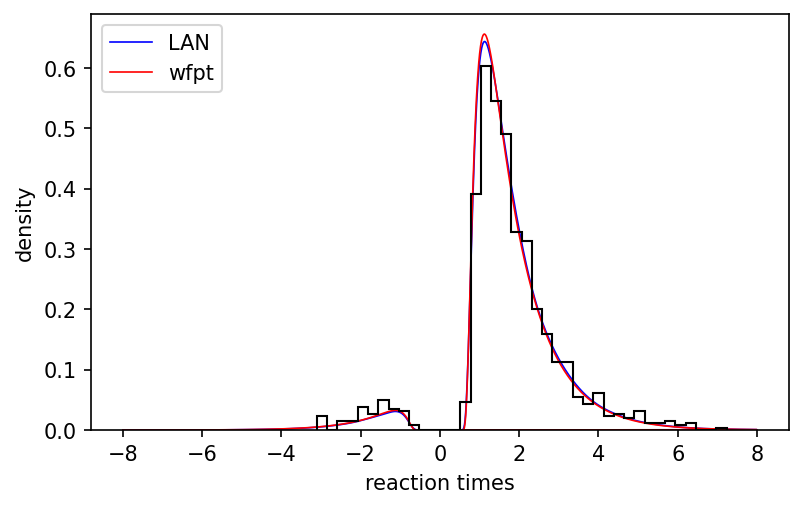

In [11]:
fig, ax = plt.subplots(figsize=(6, 3.6), dpi=150)
ax.plot(network_input[:, -2] * network_input[:, -1], prob4_list, label='LAN', lw=0.8, c='b')
ax.plot(network_input[:, -2] * network_input[:, -1], prob1_list, label='wfpt', lw=0.8, c='r')

ax.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black", density=True
)
ax.set_xlabel("reaction times")
ax.set_ylabel("density")
ax.legend()
plt.show()

#### test 2: For the Angle model with $\theta\neq0$

In [12]:
mu = 1
a = 1.5
z = 0.5
t_nd = 0.5
theta = 0.3
out = simulator(model="angle", theta=[mu, a, z, t_nd, theta], n_samples=1000)

In [13]:
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)

T_list = np.linspace(.6, 8, 100)
rT_list = np.hstack((T_list, T_list)).reshape(-1, 1)
choice_list = np.hstack((np.ones(T_list.shape), -np.ones(T_list.shape))).reshape(-1, 1)
para_matrix = np.tile(np.array([mu, a, z, t_nd, theta]), (200, 1))
network_input = np.hstack((para_matrix, rT_list, choice_list)).astype(np.float32)
prob4_list = np.exp(lan_angle(network_input))

prob2a_list = []
for T in T_list:
    print("{:.4f}".format(T), end=" ")
    prob2 = mc.ExitProb_dp(T=T, s=mc.upper_bdy(T-mc.t_nd)) / mc.dt
    prob2a_list.append(prob2)
    gc.collect()
print()
for T in T_list:
    print("{:.4f}".format(-T), end=" ")
    prob2 = mc.ExitProb_dp(T=T, s=mc.lower_bdy(T-mc.t_nd)) / mc.dt
    prob2a_list.append(prob2)
    gc.collect()


0.6000 0.6747 0.7495 0.8242 0.8990 0.9737 1.0485 1.1232 1.1980 1.2727 1.3475 1.4222 1.4970 1.5717 1.6465 1.7212 1.7960 1.8707 1.9455 2.0202 

2.0949 2.1697 2.2444 2.3192 2.3939 2.4687 2.5434 2.6182 2.6929 2.7677 2.8424 2.9172 2.9919 3.0667 3.1414 3.2162 3.2909 3.3657 3.4404 3.5152 3.5899 3.6646 3.7394 3.8141 3.8889 3.9636 4.0384 4.1131 4.1879 4.2626 4.3374 4.4121 4.4869 4.5616 4.6364 4.7111 4.7859 4.8606 4.9354 5.0101 5.0848 5.1596 5.2343 5.3091 5.3838 5.4586 5.5333 5.6081 5.6828 5.7576 5.8323 5.9071 5.9818 6.0566 6.1313 6.2061 6.2808 6.3556 6.4303 6.5051 6.5798 6.6545 6.7293 6.8040 6.8788 6.9535 7.0283 7.1030 7.1778 7.2525 7.3273 7.4020 7.4768 7.5515 7.6263 7.7010 7.7758 7.8505 7.9253 8.0000 
-0.6000 -0.6747 -0.7495 -0.8242 -0.8990 -0.9737 -1.0485 -1.1232 -1.1980 -1.2727 -1.3475 -1.4222 -1.4970 -1.5717 -1.6465 -1.7212 -1.7960 -1.8707 -1.9455 -2.0202 -2.0949 -2.1697 -2.2444 -2.3192 -2.3939 -2.4687 -2.5434 -2.6182 -2.6929 -2.7677 -2.8424 -2.9172 -2.9919 -3.0667 -3.1414 -3.2162 -3.2909 -3.3657 -3.4404 -3.5152 -3.5899 -3.6646 -3.7394 -3.8141 -3.8889 -3.9636 -4.0384 -4.1131 -4.1879 -4.2626 -4.3374 -4.4121 -4.4869 -4.5616 -4.6364

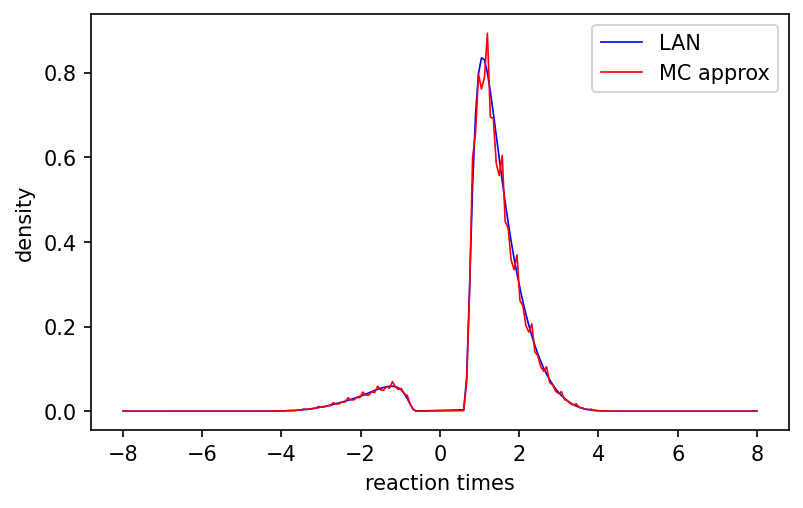

In [14]:
sort_idx = np.argsort(network_input[:, -2] * network_input[:, -1])
signedT_list = (network_input[:, -2] * network_input[:, -1])[sort_idx]
prob4_list = prob4_list[sort_idx]
prob2a_list = np.array(prob2a_list)[sort_idx]

fig, ax = plt.subplots(figsize=(6, 3.6), dpi=150)
ax.plot(signedT_list, prob4_list, label="LAN", lw=0.8, c="b")
ax.plot(signedT_list, prob2a_list, label="MC approx", lw=0.8, c="r")

# ax.hist(
#     np.squeeze(out[0]) * np.squeeze(out[1]),
#     histtype="step",
#     bins=40,
#     color="black",
#     density=True,
# )
ax.set_xlabel("reaction times")
ax.set_ylabel("density")
ax.legend()
plt.show()


In [15]:
mc = MC_Angle(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0002, Nx=200)

T_list = np.linspace(.6, 8, 100)
rT_list = np.hstack((T_list, T_list)).reshape(-1, 1)
choice_list = np.hstack((np.ones(T_list.shape), -np.ones(T_list.shape))).reshape(-1, 1)
para_matrix = np.tile(np.array([mu, a, z, t_nd, theta]), (200, 1))
network_input = np.hstack((para_matrix, rT_list, choice_list)).astype(np.float32)
prob4_list = np.exp(lan_angle(network_input))


prob2b_list = []
for T in T_list:
    print("{:.4f}".format(T), end=" ")
    prob2 = mc.ExitProb_dp(T=T, s=mc.upper_bdy(T-mc.t_nd)) / mc.dt
    prob2b_list.append(prob2)
    gc.collect()
print()
for T in T_list:
    print("{:.4f}".format(-T), end=" ")
    prob2 = mc.ExitProb_dp(T=T, s=mc.lower_bdy(T-mc.t_nd)) / mc.dt
    prob2b_list.append(prob2)
    gc.collect()


0.6000 0.6747 0.7495 0.8242 0.8990 

0.9737 1.0485 1.1232 1.1980 1.2727 1.3475 1.4222 1.4970 1.5717 1.6465 1.7212 1.7960 1.8707 1.9455 2.0202 2.0949 2.1697 2.2444 2.3192 2.3939 2.4687 2.5434 2.6182 2.6929 2.7677 2.8424 2.9172 2.9919 3.0667 3.1414 3.2162 3.2909 3.3657 3.4404 3.5152 3.5899 3.6646 3.7394 3.8141 3.8889 3.9636 4.0384 4.1131 4.1879 4.2626 4.3374 4.4121 4.4869 4.5616 4.6364 4.7111 4.7859 4.8606 4.9354 5.0101 5.0848 5.1596 5.2343 5.3091 5.3838 5.4586 5.5333 5.6081 5.6828 5.7576 5.8323 5.9071 5.9818 6.0566 6.1313 6.2061 6.2808 6.3556 6.4303 6.5051 6.5798 6.6545 6.7293 6.8040 6.8788 6.9535 7.0283 7.1030 7.1778 7.2525 7.3273 7.4020 7.4768 7.5515 7.6263 7.7010 7.7758 7.8505 7.9253 8.0000 
-0.6000 -0.6747 -0.7495 -0.8242 -0.8990 -0.9737 -1.0485 -1.1232 -1.1980 -1.2727 -1.3475 -1.4222 -1.4970 -1.5717 -1.6465 -1.7212 -1.7960 -1.8707 -1.9455 -2.0202 -2.0949 -2.1697 -2.2444 -2.3192 -2.3939 -2.4687 -2.5434 -2.6182 -2.6929 -2.7677 -2.8424 -2.9172 -2.9919 -3.0667 -3.1414 -3.2162 -3.2909 -3.3657 -3.4404 -3.5152 -3.5899 -3.664

In [16]:
sort_idx = np.argsort(network_input[:, -2] * network_input[:, -1])
signedT_list = (network_input[:, -2] * network_input[:, -1])[sort_idx]
prob4_list = prob4_list[sort_idx]
prob2b_list = np.array(prob2b_list)[sort_idx]


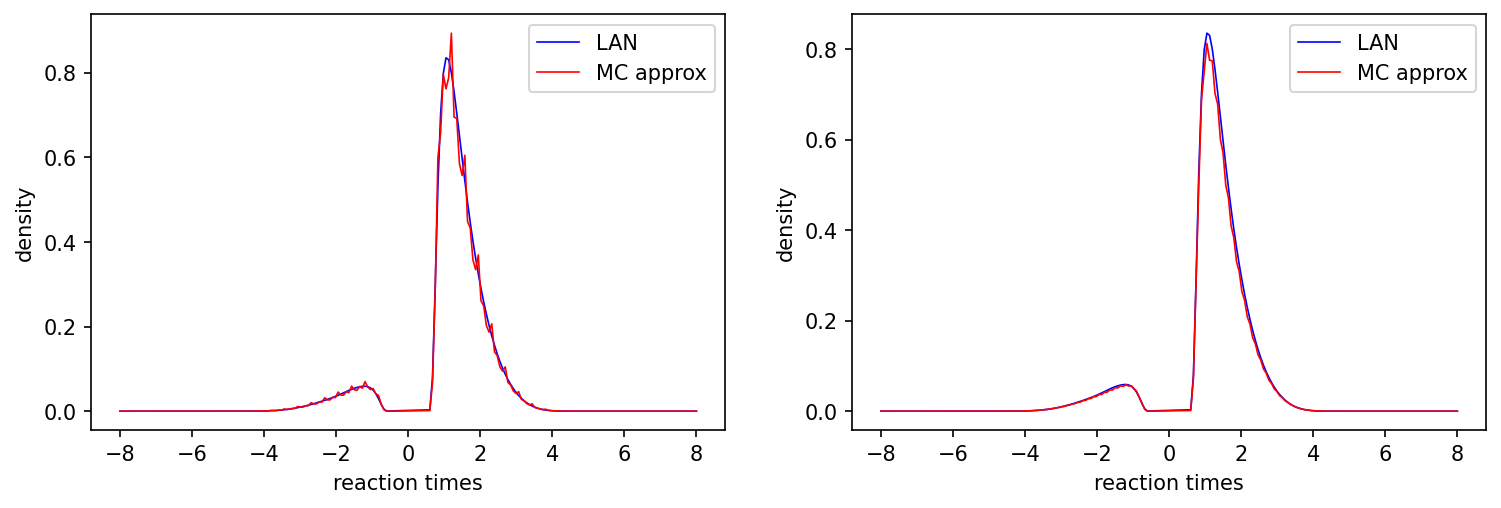

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12, 3.6), dpi=150)
ax[0].plot(signedT_list, prob4_list, label="LAN", lw=0.8, c="b")
ax[0].plot(signedT_list, prob2a_list, label="MC approx", lw=0.8, c="r")
ax[1].plot(signedT_list, prob4_list, label="LAN", lw=0.8, c="b")
ax[1].plot(signedT_list, prob2b_list, label="MC approx", lw=0.8, c="r")

# ax.hist(
#     np.squeeze(out[0]) * np.squeeze(out[1]),
#     histtype="step",
#     bins=40,
#     color="black",
#     density=True,
# )
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")
ax[0].legend()
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")
ax[1].legend()
plt.show()